In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy import stats

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Open file and load data

In [5]:
# load csv file
original_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/herb flower data/Mohonk_Summary_HERBS.csv', encoding='ISO-8859-1')

In [17]:
# create a copy of data
df = original_data.copy()


In [18]:
# view the first few entries of the data
df.head()

,Common_Name,Scientific_Name,Year,JD_First_Fls
0,agueweed,Gentiana_clausa,1979,235.0
1,agueweed,Gentiana_clausa,1994,270.0
2,agueweed,Gentiana_clausa,1995,248.0
3,agueweed,Gentiana_clausa,2004,274.0
4,agueweed,Gentiana_clausa,2007,266.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Common_Name      2445 non-null   object 
 1   Scientific_Name  2445 non-null   object 
 2   Year             2445 non-null   int64  
 3   JD_First_Fls     2445 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 76.5+ KB


In [20]:
category_list = df['Scientific_Name'].unique()
print('There are',len(category_list),'unique scientific names')

There are 108 unique scientific names


## Map each plant name to the associated subset of data

In [24]:
# create hash map to map unique categories to the data points falling into those categories
categorized_data = {}

# for each category group observed in df, map the associated data to the category group
for category in category_list:
  filter1 = df["Scientific_Name"]==category

  categorized_data.update({category:df.where(filter1, inplace = False).dropna()})

## Visualize and Example

In [25]:
# view data associated with a given category group
example_data = categorized_data.get('Gentiana_clausa')
# example_data = categorized_data.get(('Home', 'graminifolia', 'Euthamia'))
# (Vassar_College_Ecological_Preserve, capensis, Impatiens)

# you can look up different category groups by editing the above line of code, inside of the .get() function provide your categories as follows:
# ('Site','specie', 'genera')

# view data
example_data

,Common_Name,Scientific_Name,Year,JD_First_Fls
0,agueweed,Gentiana_clausa,1979.0,235.0
1,agueweed,Gentiana_clausa,1994.0,270.0
2,agueweed,Gentiana_clausa,1995.0,248.0
3,agueweed,Gentiana_clausa,2004.0,274.0
4,agueweed,Gentiana_clausa,2007.0,266.0
5,agueweed,Gentiana_clausa,2008.0,307.0
6,agueweed,Gentiana_clausa,2010.0,253.0
7,agueweed,Gentiana_clausa,2012.0,242.0
8,agueweed,Gentiana_clausa,2017.0,248.0


## Now lets plot the example...

<Axes: xlabel='Year', ylabel='JD_First_Fls'>

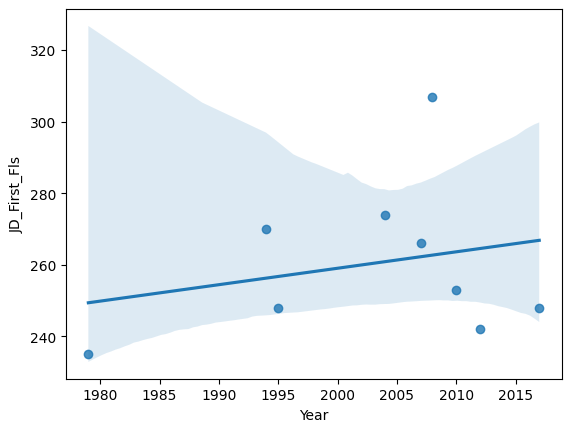

In [28]:
sns.regplot(example_data, x=example_data['Year'], y=example_data['JD_First_Fls'])

## Now let's get the correlation coefficient

In [30]:
x=example_data['Year']
y=example_data['JD_First_Fls']

round(x.corr(y),4)

0.2451

## Since there are 224 uique groupings, it doesn't make sense to visualize them all
## Let's just perform the regression, calculate some stats and store the results


In [31]:
#create a list of the various category groups and a separte list of their respective correlations
category_groups = []
pearson_correlations = []
kendall_taus = []
regression_scores = []
slopes=[]
p_values = []
results = []
results2 = []

# loop through all unique catgory groupings
for category in category_list:
  example_data = categorized_data.get(category)
  x=example_data['Year']   #reshape x data to work with sklearn linear model
  y=example_data['JD_First_Fls']
  correlation = round(x.corr(y),4)
  tau, p_value = stats.kendalltau(x, y)


  #run the regression via statsmodel
  x = sm.add_constant(x)
  est = sm.OLS(y,x)
  est2 = est.fit()
  if len(x) > 2:
    slopes.append(round(est2.params[1],4))
  else:
    slopes.append(pd.NA)

  p_values.append(round(est2.pvalues[0],4))
  regression_scores.append(round(est2.rsquared,4))

  category_groups.append(category)
  pearson_correlations.append(correlation)
  kendall_taus.append(round(tau,4))


correlation_df = pd.DataFrame({
    'grouping':category_groups,
    'Pearson r': pearson_correlations,
    'Kendall τ': kendall_taus,
    'slope':slopes,
    'R²' : regression_scores,
    'p-value':p_values
})


In [32]:
# drop all rows containing NaN values (these seem to usually result from instances where there is only one DOY observation)
correlation_df = correlation_df.dropna()

# view catergories & correlation
print(correlation_df.to_string())
print(len(correlation_df), 'total instances')

                         grouping  Pearson r  Kendall τ   slope      R²  p-value
0                 Gentiana_clausa     0.2451    -0.0282  0.4595  0.0601   0.6461
1          Minuartia groenlandica    -0.5171    -0.2009 -0.9065  0.2674   0.0034
2             Penstemon_digitalis    -0.8718    -0.6156 -0.4227  0.7601   0.0000
3              Lotus_corniculatus    -0.4492    -0.2236 -0.6024  0.2018   0.0168
4               Solanum_dulcamara    -0.4712    -0.1700 -1.3736  0.2221   0.0871
5                 Actaea racemosa    -0.6493    -0.6190 -0.8357  0.4216   0.0862
6                 Silene_vulgaris    -0.2305    -0.1604 -0.1703  0.0531   0.2159
7          Sanguinaria_canadensis    -0.3970    -0.2669 -0.1376  0.1576   0.0001
8                  Aralia_hispida    -0.4176    -0.3333 -0.3288  0.1744   0.0822
9                 Iris_versicolor    -0.4291    -0.2556 -0.1970  0.1841   0.0377
10             Clintonia_borealis    -0.7624    -0.4286 -0.9405  0.5813   0.0353
11     Sisyrinchium_angustif

In [33]:
correlation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pearson r,108.0,-0.428236,0.253383,-0.9388,-0.607500,-0.46305,-0.280700,0.2451
Kendall τ,108.0,-0.285291,0.189672,-0.9129,-0.407175,-0.27380,-0.189125,0.1952
slope,108.0,-0.363367,0.309457,-1.3736,-0.550000,-0.30400,-0.169500,0.4595
R²,108.0,0.246987,0.192440,0.0000,0.078825,0.21440,0.369050,0.8814
p-value,108.0,0.129194,0.240102,0.0000,0.001575,0.01545,0.096225,0.9881


# Let's reduce our results to groupings that saw a p-value < .1
## Sorted by p-value


In [34]:
significant = correlation_df[correlation_df['p-value']<.10].sort_values('p-value')
print(significant.to_string())
print(len(significant), 'instances in total')

                         grouping  Pearson r  Kendall τ   slope      R²  p-value
72               Trillium_erectum    -0.5046    -0.3456 -0.1671  0.2547   0.0000
16                Cirsium_arvense    -0.7662    -0.6595 -0.6434  0.5871   0.0000
13                Cirsium_vulgare    -0.6979    -0.4331 -0.7368  0.4871   0.0000
85         Erythronium_americanum    -0.5207    -0.3487 -0.1450  0.2711   0.0000
63             Cypripedium acaule    -0.6052    -0.3812 -0.2657  0.3662   0.0000
20              Tussilago_farfara    -0.7295    -0.5065 -0.5638  0.5321   0.0000
88            Ageratina_altissima    -0.6711    -0.5250 -1.1259  0.4503   0.0000
35                Panax_trifolius    -0.7247    -0.5343 -0.4244  0.5252   0.0000
2             Penstemon_digitalis    -0.8718    -0.6156 -0.4227  0.7601   0.0000
74       Thalictrum_thalictroides    -0.4357    -0.2635 -0.1983  0.1898   0.0001
66            Antennaria_neglecta    -0.7438    -0.5134 -0.7242  0.5532   0.0001
103              Iris pseuda

### Descriptive Statistics of Instance with p-value < .10:

In [35]:
significant.describe().T

,count,mean,std,min,25%,50%,75%,max
Pearson r,81.0,-0.535289,0.159717,-0.9388,-0.6711,-0.5183,-0.4357,-0.1608
Kendall τ,81.0,-0.354404,0.145775,-0.9129,-0.4286,-0.3333,-0.2556,-0.1210
slope,81.0,-0.455277,0.277395,-1.3736,-0.5834,-0.4243,-0.2400,-0.0782
R²,81.0,0.311721,0.173397,0.0259,0.1898,0.2686,0.4503,0.8814
p-value,81.0,0.019195,0.027879,0.0000,0.0009,0.0046,0.0279,0.0942


## Now let's break them down by slope...
#Positive Slope:

In [36]:
positive_slopes = significant[significant['slope']>0].sort_values('slope')
print(positive_slopes.to_string())

Empty DataFrame
Columns: [grouping, Pearson r, Kendall τ, slope, R², p-value]
Index: []


# Negative Slope:

In [41]:
negative_slopes = significant[significant['slope']<0].sort_values('slope')

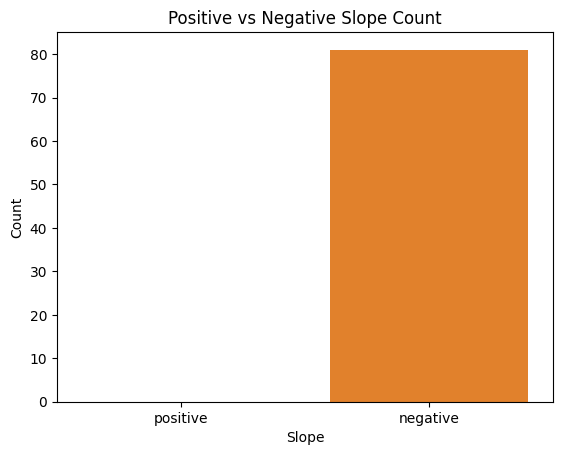

Number of positive slope examples: 0
Number of negative slope examples: 81


In [42]:
# Create a DataFrame
df = pd.DataFrame({
    'Array': ['positive', 'negative'],
    'Length': [len(positive_slopes), len(negative_slopes)]
})

# Create the plot
plot = sns.barplot(x='Array', y='Length', data=df)

# Set the title
plot.set_title('Positive vs Negative Slope Count')

# Set x and y-axis labels
plot.set_xlabel('Slope')
plot.set_ylabel('Count')

plt.show()

print('Number of positive slope examples:',len(positive_slopes))
print('Number of negative slope examples:',len(negative_slopes))

## 81, out of the original 108, groupings showed a statistically significant (p < .10) relationship between year and JD_First_Fls
##0 have a positive slope
##all 81 have a negative slope